# Starbucks Sentiment Analysis 2018
An analysis of online comments at http://reddit.com. 




In [2]:
### Import Python Libraries
import numpy as np
import pandas as pd
import datetime

#Graphing Libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

#pd.set_option('display.max_colwidth', None)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



### Connect to Google Cloud Platform

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

key_location =  '/Users/steve/Documents/Programming/Keys/Google/Starbucks-Sentiment-e50e32624349.json'
credentials = service_account.Credentials.from_service_account_file(key_location)


project_id = 'starbucks-sentiment'
client = bigquery.Client(credentials=credentials,project=project_id)



### Pulls discussion threads that have a mention of Starbucks

In [3]:


sql = """with base_query as
(select *
  FROM
  (select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_01`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_02`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_03`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_04`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_05`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_06`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_07`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_08`
    union all
select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_09`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_10`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_11`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_12`
  )
)
Select * from base_query
WHERE
   score > 1 AND body LIKE '%Starbucks%'
   and length(body) > 20
"""


pull_data = False

if pull_data:
    print('Pull data from online')
    query_job = client.query(sql)
    df = query_job.result().to_dataframe()     
    df.drop(['parent_id','score','controversiality'],axis=1,inplace=True)
    df['created_utc'] = df['created_utc'].apply(lambda dt:datetime.datetime.utcfromtimestamp(dt))

else:
    print('Pull data from local file.')
    df = pd.read_pickle('Starbucks_Comments_2017_2018.pickle')
    print('df shape',df.shape)
    df2 = pd.read_pickle('Starbucks_Comments_2019.pickle')
    print('df2 shape',df2.shape)
    df.reset_index(drop=True,inplace=True)
    df2.reset_index(drop=True,inplace=True)
    
    frames = [df,df2]
    df = pd.concat(frames)
    print('combined',df.shape)
    
    

#df.set_index('created_utc',inplace=True,drop=False)

Pull data from local file.
df shape (236051, 3)
df2 shape (147288, 3)
combined (383339, 3)


In [4]:
df.head()

,subreddit,created_utc,body
0,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...
1,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?
2,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec..."
3,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...
4,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar..."


## Create a Pandas dataframe

In [5]:

df.set_index('created_utc',inplace=True,drop=False)
df.head()

,subreddit,created_utc,body
created_utc,,,
2018-12-28 00:17:21,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...
2018-12-06 00:32:31,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?
2018-12-04 01:26:05,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec..."
2018-12-30 01:26:05,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...
2018-12-03 01:21:10,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar..."


In [11]:
df.shape

(383339, 3)

## Natural Language Processing

In [6]:
#VADER

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    def parse_sentences(text):
        blob = TextBlob(text)
        blob = blob.lower()
        return [sentence for sentence in blob.sentences]

    def polarities(sentences):
        sentence_polarities = []
        for sent in sentences:
            vs = analyzer.polarity_scores(sent)
            sentence_polarities.append (vs['compound'])
        return sentence_polarities
    def sentiment_label(polarities):
        #print('Polarities',polarities)
        return list(map(vader_polarity_label, polarities))
    
    return sentiment_label(polarities(parse_sentences(text)))




def vader_polarity_label(polarity_value):
    try:
        if polarity_value >= 0.05:
            return 'Positive'
        elif polarity_value <= -0.05:
            return 'Negative'
        elif polarity_value >-0.05 and polarity_value <0.05:
            return 'Neutral'
        else:
            return 'Unknown'
    except:
        pass

    
    

### Break comments into sentences and apply sentiment analysis using Textblob

In [30]:
apply_sentiment = False

if apply_sentiment == True:
    df['sentiment'] = df['body'].apply(lambda x: vader_sentiment(x))
else:
    #df = pd.read_pickle('comments_with_sentiment.pickle')
    df = pd.read_pickle('comments_with_vader_sentiments.pickle')



### Sum the number of Positive, Negative, and Neutral comments in each post

In [31]:
def count_values(searched_list,target_text):
    return searched_list.count(target_text)


df['Positive'] = df['sentiment'].apply(lambda x: count_values(x,'Positive'))
df['Negative'] =df['sentiment'].apply(lambda x: count_values(x,'Negative'))
df['Neutral'] =df['sentiment'].apply(lambda x: count_values(x,'Neutral'))
df.drop(['sentiment'],axis=1,inplace=True)
df.head()

,subreddit,created_utc,body,Positive,Negative,Neutral
created_utc,,,,,,
2018-12-28 00:17:21,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...,0,0,1
2018-12-06 00:32:31,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?,0,0,1
2018-12-04 01:26:05,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec...",1,0,0
2018-12-30 01:26:05,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...,2,2,3
2018-12-03 01:21:10,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar...",2,1,1


In [32]:
df_backup = df.copy()

In [33]:
df = df_backup.copy()
df.shape

(383339, 6)

Tally sentiments by date.

In [34]:
df.set_index('created_utc',drop=False,inplace=True)
df.head()

,subreddit,created_utc,body,Positive,Negative,Neutral
created_utc,,,,,,
2018-12-28 00:17:21,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...,0,0,1
2018-12-06 00:32:31,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?,0,0,1
2018-12-04 01:26:05,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec...",1,0,0
2018-12-30 01:26:05,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...,2,2,3
2018-12-03 01:21:10,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar...",2,1,1


In [35]:

df = df.resample('D').sum().reset_index()
df.head()

,created_utc,Positive,Negative,Neutral
0,2017-01-01,374,198,343
1,2017-01-02,455,318,488
2,2017-01-03,571,354,543
3,2017-01-04,562,269,527
4,2017-01-05,517,304,493


In [12]:
#df.to_csv('vader_Sentiment_Totals_by_Date.csv')

## Graph Results

## Important Dates

# 


In [36]:
arrest_date = '2018-04-12'
arrest_date = datetime.datetime.strptime(arrest_date, '%Y-%m-%d')
apology_date = '2018-04-15'
apology_date = datetime.datetime.strptime(apology_date, '%Y-%m-%d')
close_date = '2018-05-29'
close_date = datetime.datetime.strptime(close_date, '%Y-%m-%d')
settlement_date = '2018-05-02'

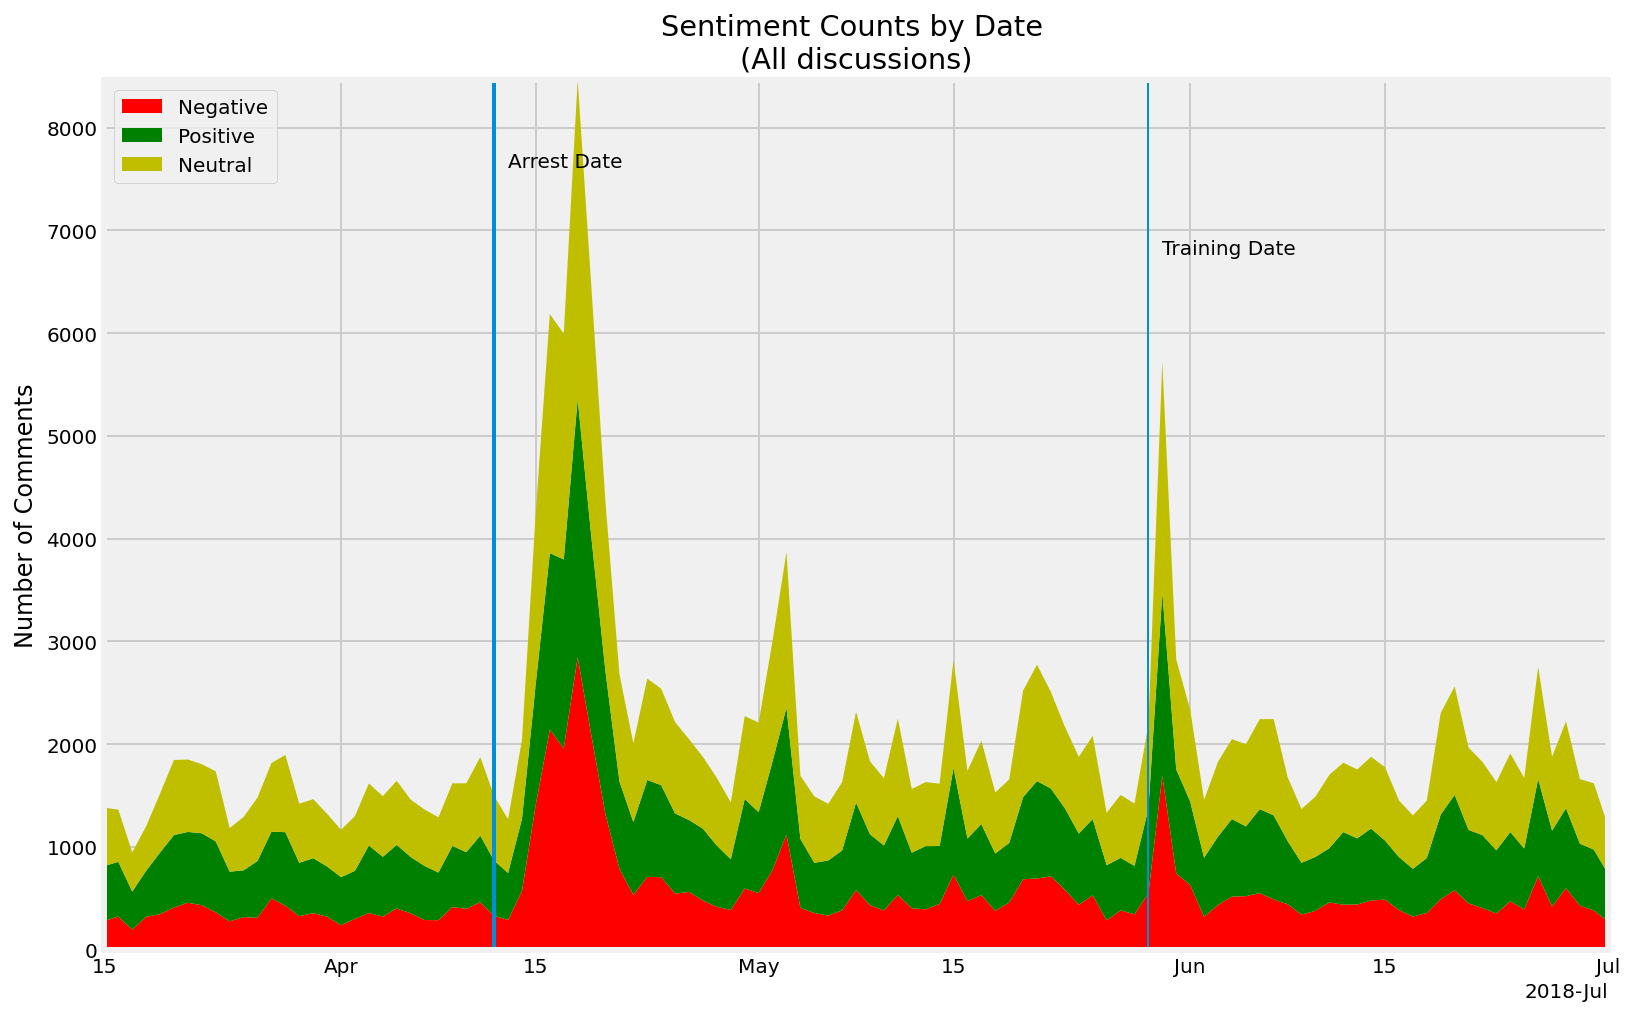

In [51]:

# All Discussion Threads
from matplotlib.dates import AutoDateLocator
from matplotlib.dates import ConciseDateFormatter

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)


df_plot = df.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')


plt.figure(figsize=(12,8)) 
plt.stackplot(df_plot['created_utc'],df_plot["Negative"].rolling(window=1).mean(),  df_plot["Positive"].rolling(window=1).mean(),  df_plot["Neutral"].rolling(window=1).mean(), labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)
close_line = ax.axvline(close_date,linewidth=1)


ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.8, 'Training Date', transform=trans)
        
        
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(All discussions)')
plt.savefig('starbucks_sentiments_by_date.svg', format='svg', dpi=1200)
plt.show()



In [27]:
#plt.savefig('starbucks_sentiments_apr_jul_2018.jpg')

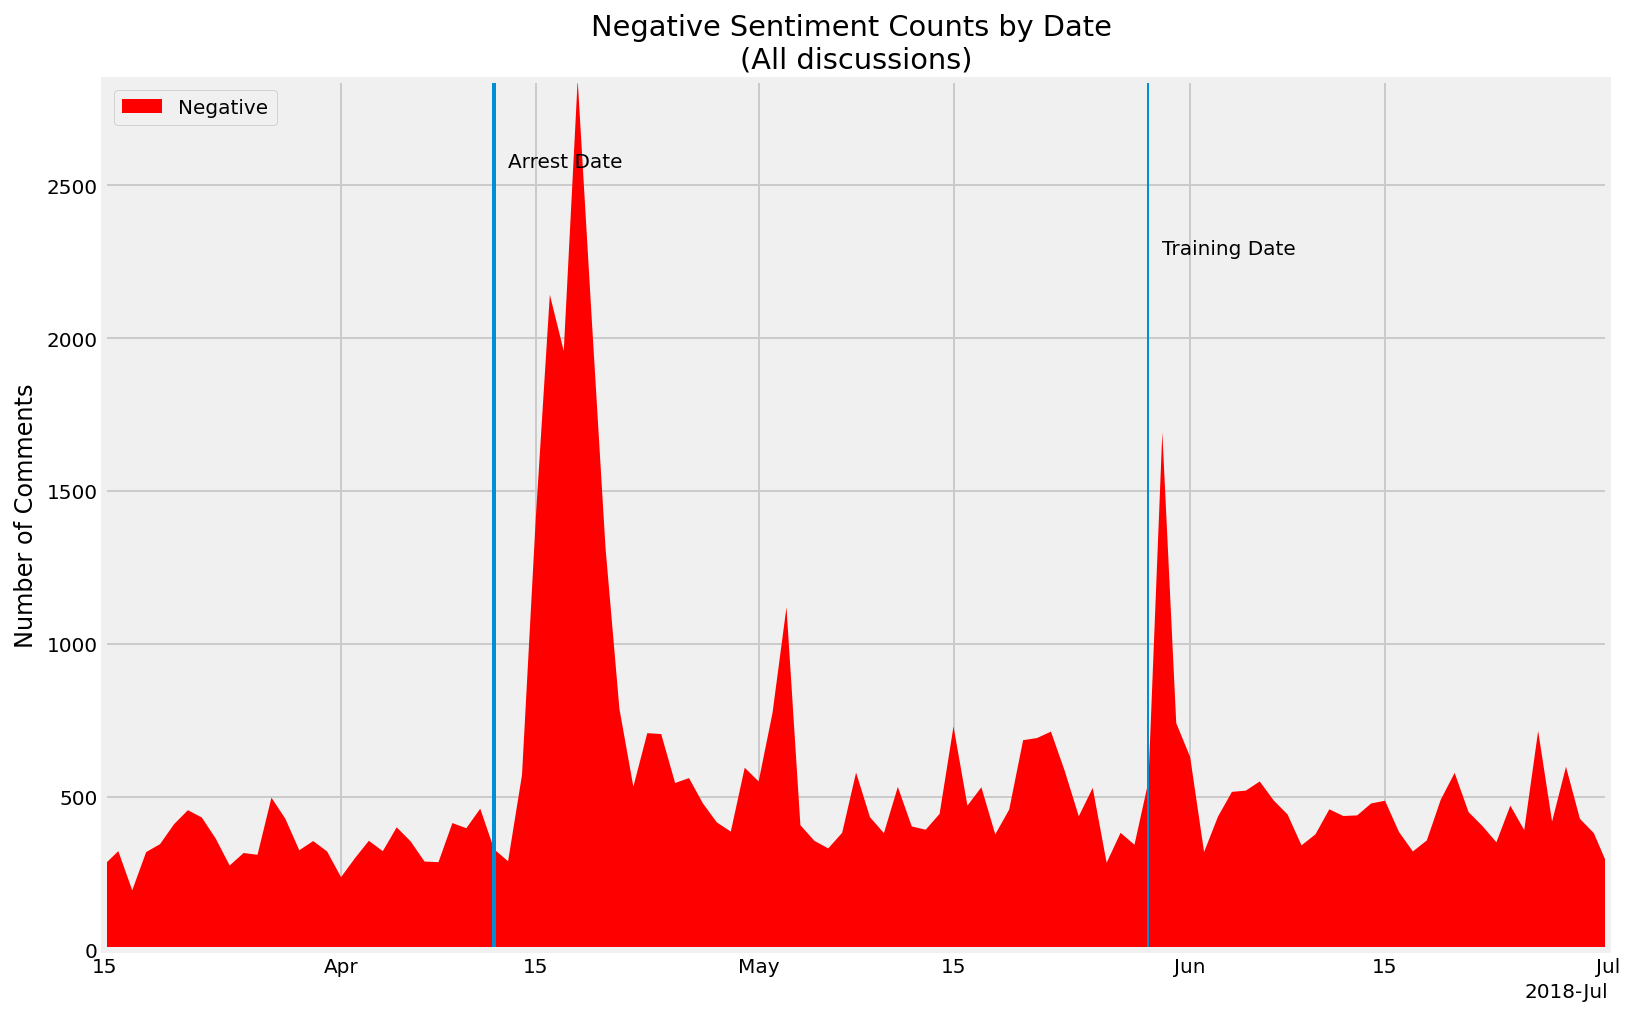

In [52]:
df_plot = df.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')

plt.figure(figsize=(12,8)) 
plt.stackplot(df_plot['created_utc'],df_plot["Negative"], labels=['Negative'],colors=['r'])
plt.legend(loc='upper left')



ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)
close_line = ax.axvline(close_date,linewidth=1)
ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.8, 'Training Date', transform=trans)
        
        
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Negative Sentiment Counts by Date \n(All discussions)')
plt.savefig('Negative_Sentiments.svg', format='svg', dpi=1200)
plt.show()

## Detecting Changes in Brand Sentiment

### Highlight those days where comments exceed what is expected

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


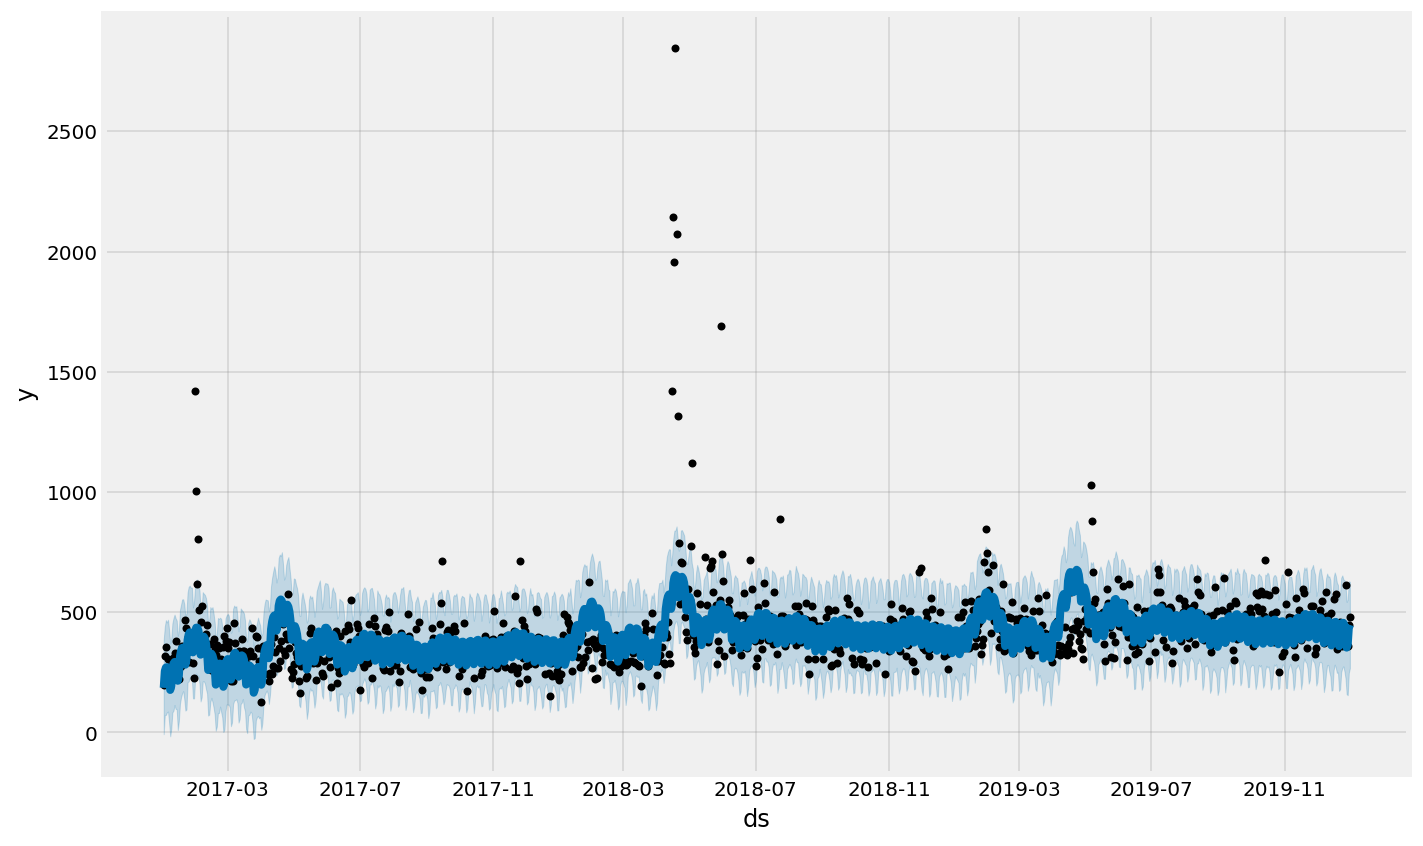

In [41]:
from fbprophet import Prophet

df_fb = df.copy()
#df_fb['created_utc'] = pd.to_datetime(df_fb['created_utc'], format='%Y/%m/%d')
df_fb.drop(['Positive','Neutral'],axis=1,inplace=True)
df_fb.rename(columns={"created_utc":"ds","Negative":"y"},inplace=True)
df_fb.drop(df_fb.columns.difference(['ds','y']), 1, inplace=True)

#Known anomalous daysl to be excluded from normal bau
starbucks_changepoints = ['2018-04-16','2018-04-17','2018-04-18','2018-04-19','2018-05-30']

m = Prophet(changepoints=starbucks_changepoints)
m.fit(df_fb)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [42]:
#Combine Actual and forecast


df_combined = df.merge(forecast,how='inner',left_on='created_utc',right_on='ds')
#df_combined['difference']= df_combined['Negative'] - df_combined['yhat']
#df_combined['pct_difference']= (df_combined['Negative'] - df_combined['yhat'])/df['Negative']




# df_combined['pct_difference']= df_combined.apply(lambda x: percentage_difference(df_combined['Negative'],df_combined['yhat']),axis=1)
df_combined['pct_diff'] = (df_combined['Negative'] - df_combined['yhat'])/df_combined['Negative']

In [43]:
df_combined.to_csv('Actual vs Forecast.csv')

In [44]:
def percent_change(current_value,next_value):
    return((current_value-next_value)/current_value)

In [45]:
#Flag those days based on some business rule.


flag_percentage = .5


def flag_change(value,flag_percentage):
    if str.isnumeric(value) & value>=flag_percentage:
        return True
    

#df_combined['flag'] = np.where(df_combined['pct_difference']>=flag_percentage,True)
df_combined['Flagged'] = df_combined['pct_diff'].apply(lambda x: True if x >=flag_percentage else 'False')


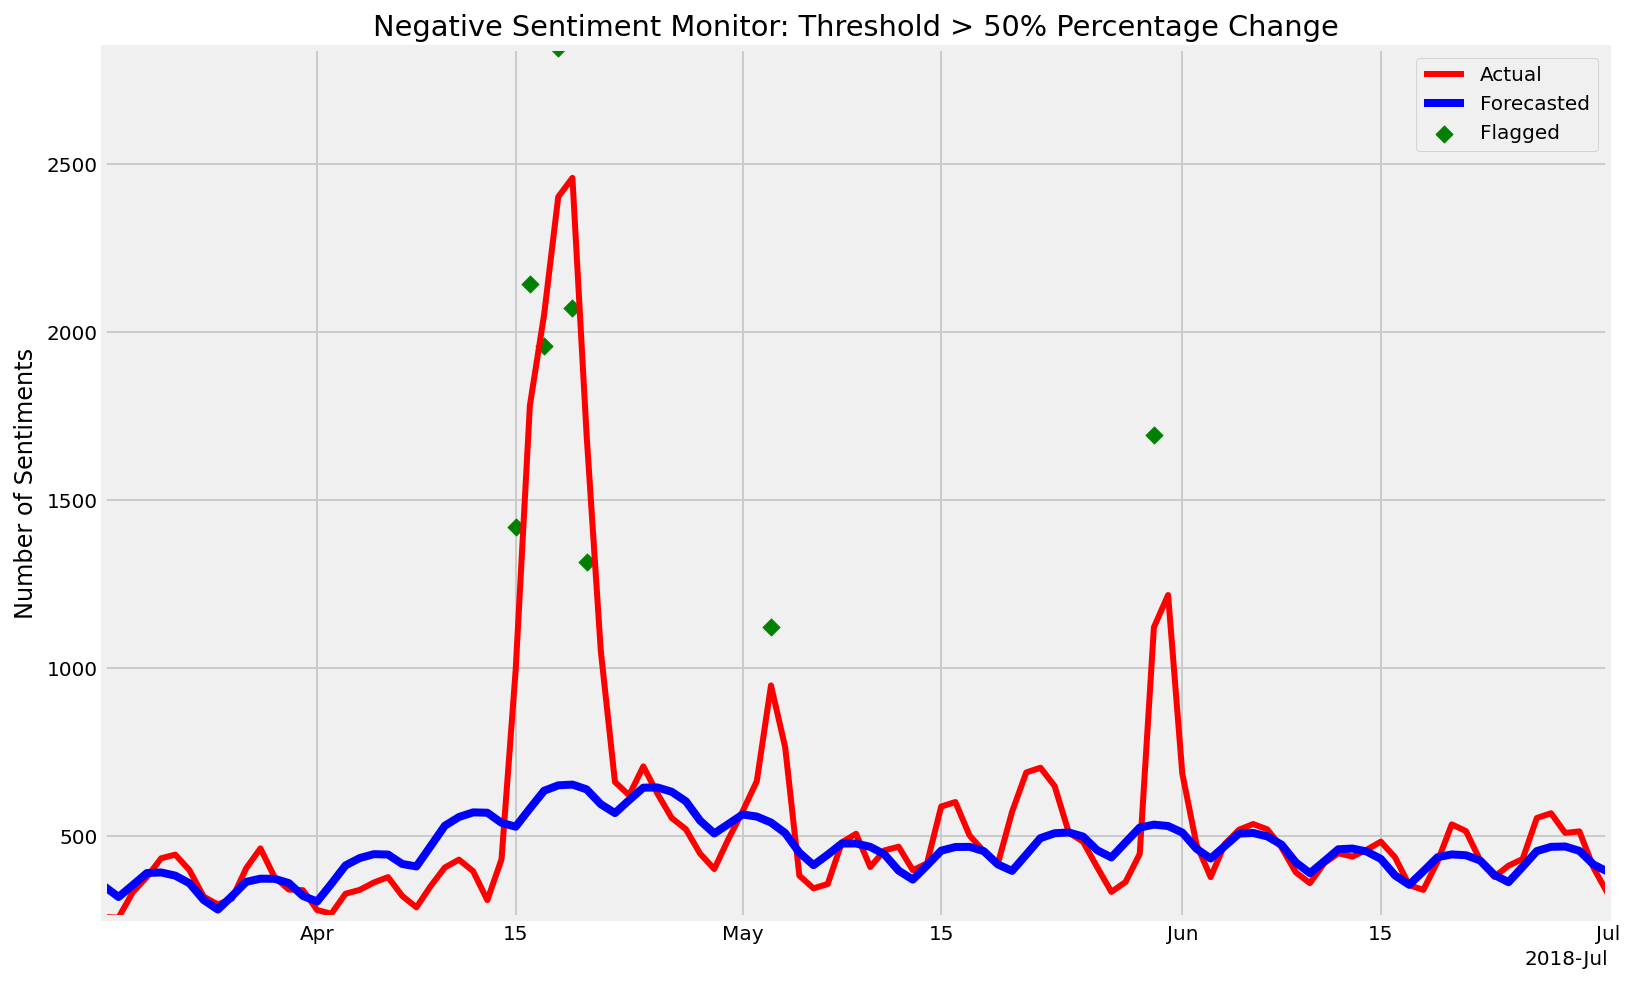

In [56]:
start_date = '03-15-2018'
end_date = '07-01-2018'


mask = (df_combined['created_utc'] > start_date) & (df_combined['created_utc'] <= end_date)
df_plot = df_combined.loc[mask].copy()

plt.figure(figsize=(12,8)) 
plt.plot(df_plot['created_utc'],df_plot["Negative"].rolling(window=2).mean(),color='r',linewidth=3,label='Actual')
plt.plot(df_plot['created_utc'],df_plot['yhat'].rolling(window=2).mean(),color='b',label='Forecasted')

df_flagged = df_plot[df_plot['Flagged']==True]



plt.scatter(df_flagged['created_utc'],df_flagged['Negative'],color='g',marker='D',label='Flagged')


ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


# plt.plot(forecast['ds'],forecast['yhat'].rolling(window=7).mean(),linewidth=1)
 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)    
    
plt.ylabel('Number of Sentiments')
plt.margins(0,0)
plt.title('Negative Sentiment Monitor: Threshold > 50% Percentage Change')
plt.savefig('Reputation Monitoring.svg',format='svg', dpi=1200)
plt.show()


In [48]:
start_date = '01-01-2018'
end_date = '06-01-2018'

df_bokeh = df.copy()
mask = (df['created_utc'] > start_date) & (df['created_utc'] <= end_date)

df_bokeh = df_bokeh.loc[mask]

#df_bokeh.set_index('created_utc',drop=True,inplace=True)

df_bokeh.head()

,created_utc,Positive,Negative,Neutral
366,2018-01-02,408,160,585
367,2018-01-03,529,247,814
368,2018-01-04,565,286,800
369,2018-01-05,665,324,1044
370,2018-01-06,526,248,785


In [49]:

from bokeh.palettes import brewer
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Spectral3
from bokeh.models import HoverTool



output_file('stacked_area.html')

hover = HoverTool(tooltips=[("Negative", "@Negative")])

fig = figure(plot_width=1200,plot_height=800,title = "Sentiment by Date",x_axis_type='datetime',tools=[hover])
fig.grid.minor_grid_line_color = '#eeeeee'


names = ['Negative','Positive','Neutral']

# fig.varea_stack(stackers=names, x='created_utc', color=brewer['Spectral'][3], legend_label=names, source=df_bokeh)
fig.varea_stack(stackers=names, x='created_utc', color=['#d7191c','#a6d96a','#fec44f'], legend_label=names,source=df_bokeh)

# hover = fig.select(dict(type=HoverTool))
# hover.tooltips = [('Num. negative sentiments:','@Negative')]
# hover.mode='mouse'

# fig.add_tools(HoverTool(tooltips=tooltips))
show(fig)

INFO:bokeh.io.state:Session output file 'stacked_area.html' already exists, will be overwritten.


In [193]:
df_bokeh.sort_values(['Negative'], ascending=False)

,created_utc,Positive,Negative,Neutral
472,2018-04-18,2274,1448,4743
470,2018-04-16,1530,1118,3536
473,2018-04-19,1829,1091,3496
471,2018-04-17,1641,1080,3274
514,2018-05-30,1738,927,3056
...,...,...,...,...
400,2018-02-05,366,163,535
377,2018-01-13,383,162,591
366,2018-01-02,408,160,585
420,2018-02-25,463,156,610


In [57]:
df_all = df.copy()
df_all['positive_perc'] = df_all['Positive'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])
df_all['neutral_perc'] = df_all['Neutral'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])
df_all['negative_perc'] = df_all['Negative'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])

In [58]:
df_all.set_index('created_utc',inplace=True,drop=False)

In [59]:
df.shape

(1095, 4)

## Plot Sentiment Percentages


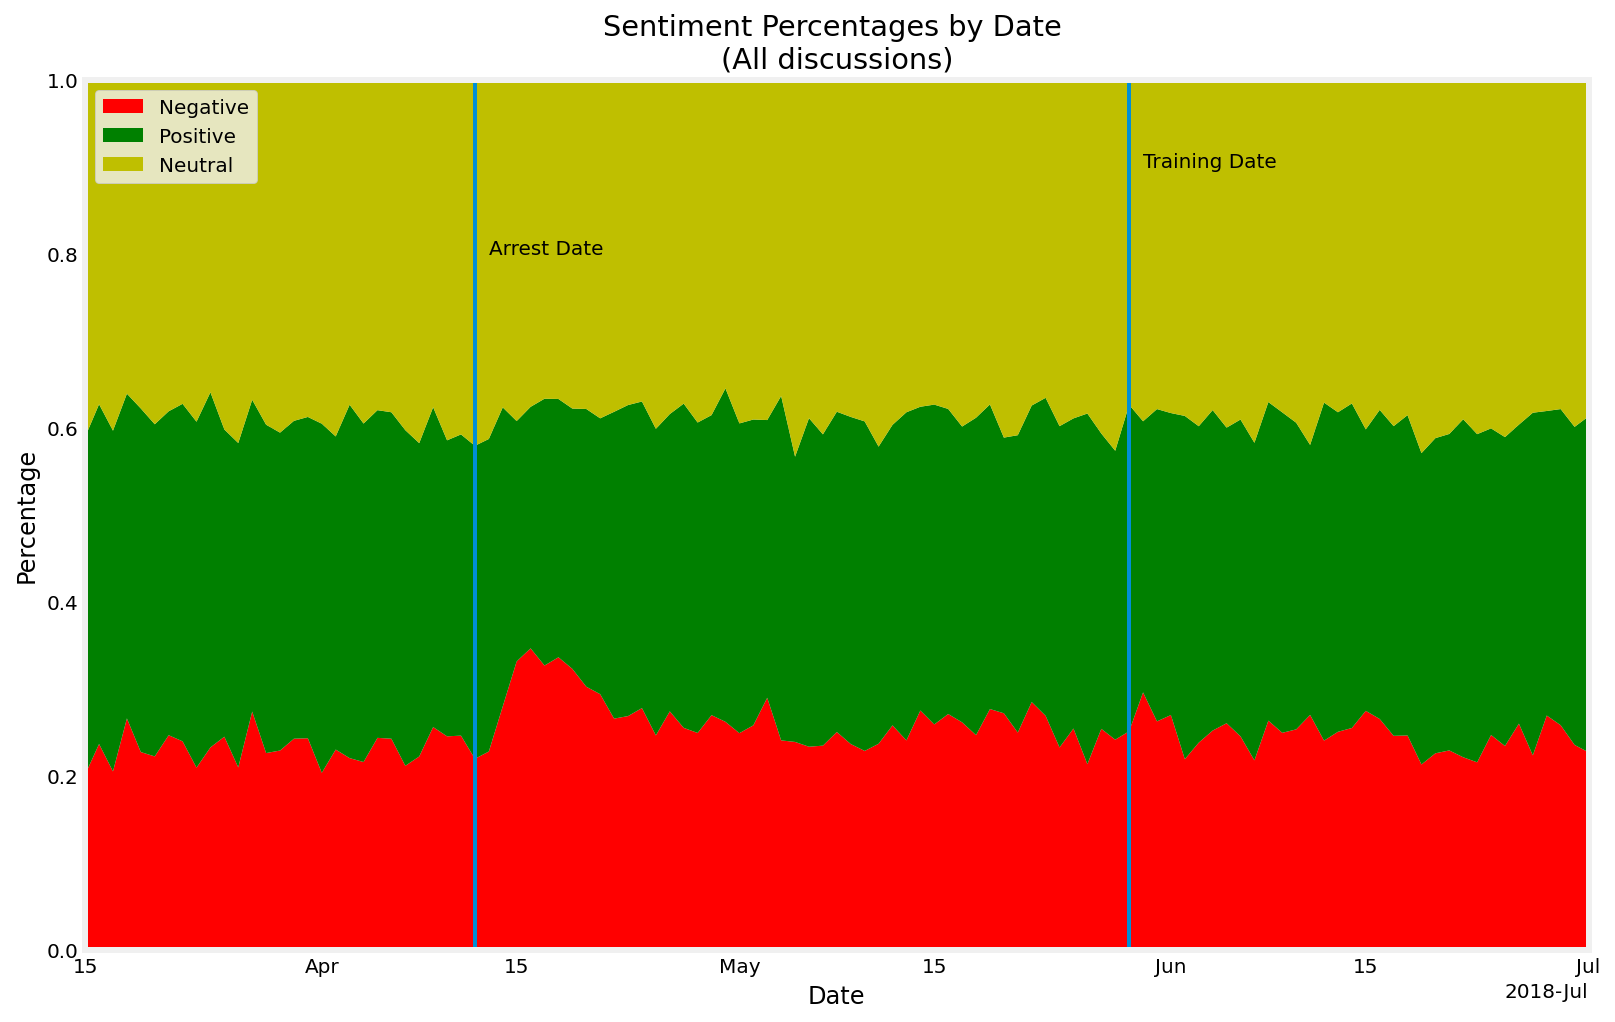

In [61]:
# Make the plot


df_all = df_all.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')

plt.figure(figsize=(12,8)) 
plt.stackplot(df_all['created_utc'],  df_all['negative_perc'],  df_all['positive_perc'],  df_all['neutral_perc'], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)

ax.axvline(close_date,linewidth=2)

ax.text(arrest_date + datetime.timedelta(days=1)  ,.8, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Sentiment Percentages by Date \n(All discussions)')
plt.savefig('Sentiment_Percentages.svg', format='svg', dpi=1200)
plt.show();

In [67]:
#plt.savefig('sentiment_percentages_by_date.jpg')

<Figure size 432x288 with 0 Axes>

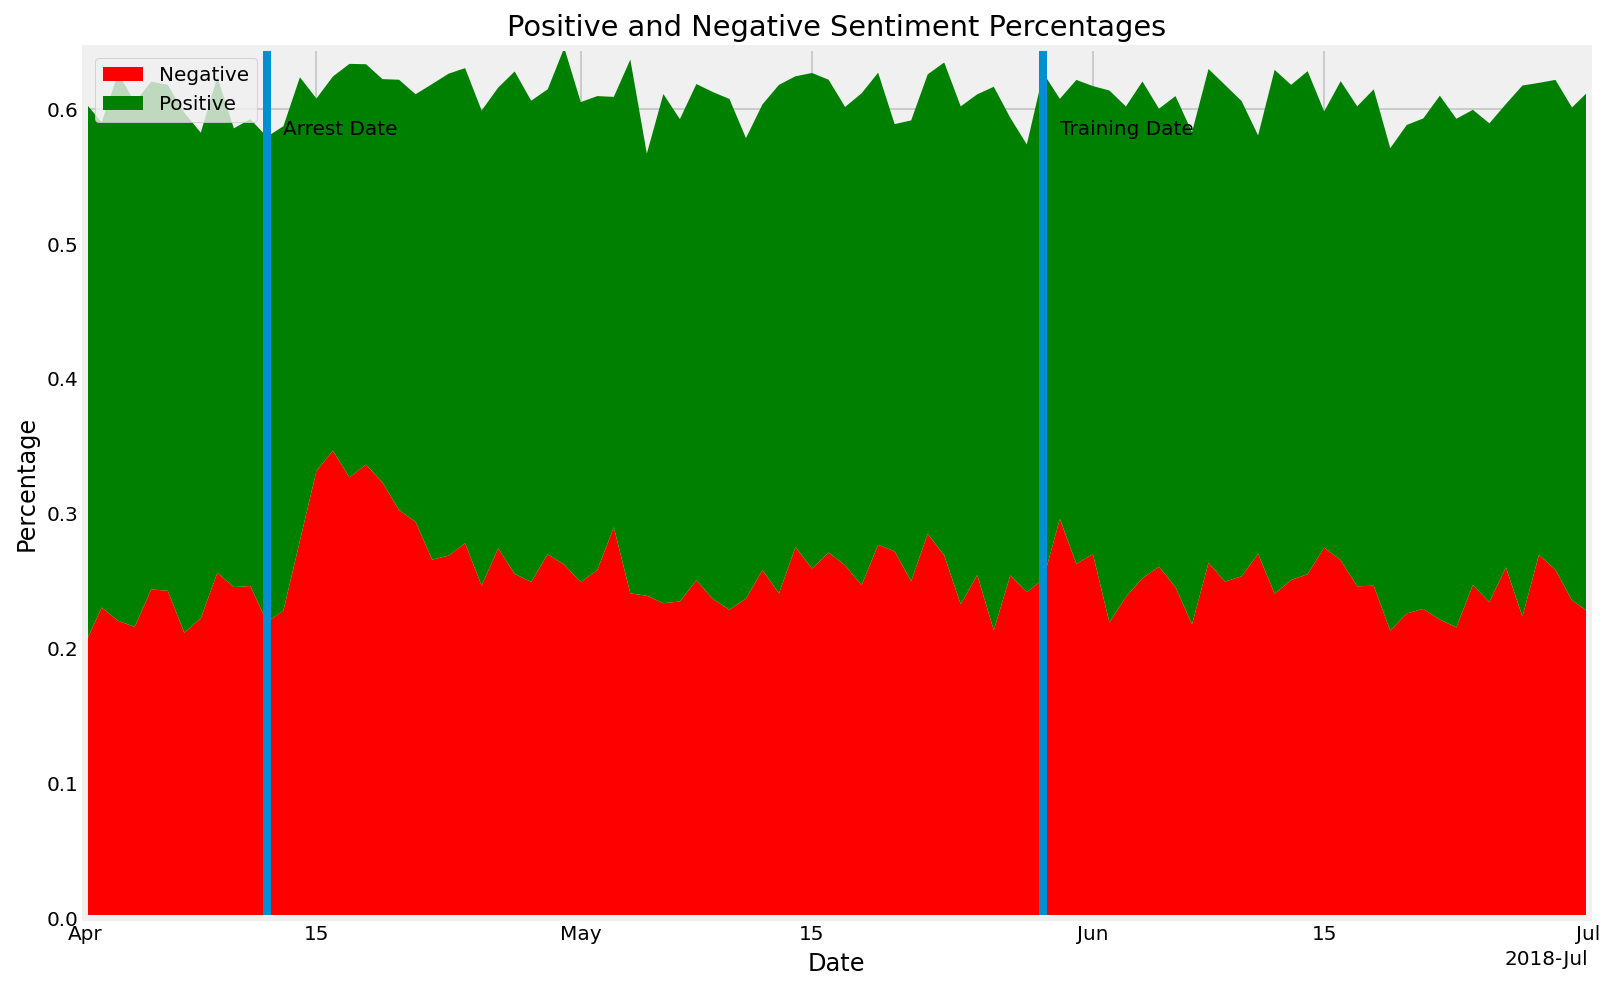

In [48]:

plt.figure(figsize=(12,8)) 
plt.stackplot(df_all['created_utc'],  df_all['negative_perc'],  df_all['positive_perc'] ,labels=['Negative','Positive'],colors=['r','g'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date) 
ax.axvline(close_date)

ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Positive and Negative Sentiment Percentages')
plt.show();

In [ ]:
df['neg_rolling']=df['Negative'].rolling(window=14).mean()

In [ ]:
neg = df['Negative']
neg_rolling = df['Negative'].rolling(window=14).mean()

neg.plot(lw=2.5,figsize=(12,8))
neg_rolling.plot()
plt.show()

In [ ]:
df2 = df.copy()
df2.head()
#df.shift(periods=3, freq="infer")
df2['prev'] = df2['Negative'].shift(periods=1)
df2['diff'] = df2['Negative']-df2['prev']
neg_comments=df2['diff']>0
df2[neg_comments]

In [30]:
df.head()

,created_utc,Positive,Negative,Neutral
0,2018-03-01,468,211,715
1,2018-03-02,488,195,701
2,2018-03-03,444,197,632
3,2018-03-04,471,176,604
4,2018-03-05,482,200,725


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


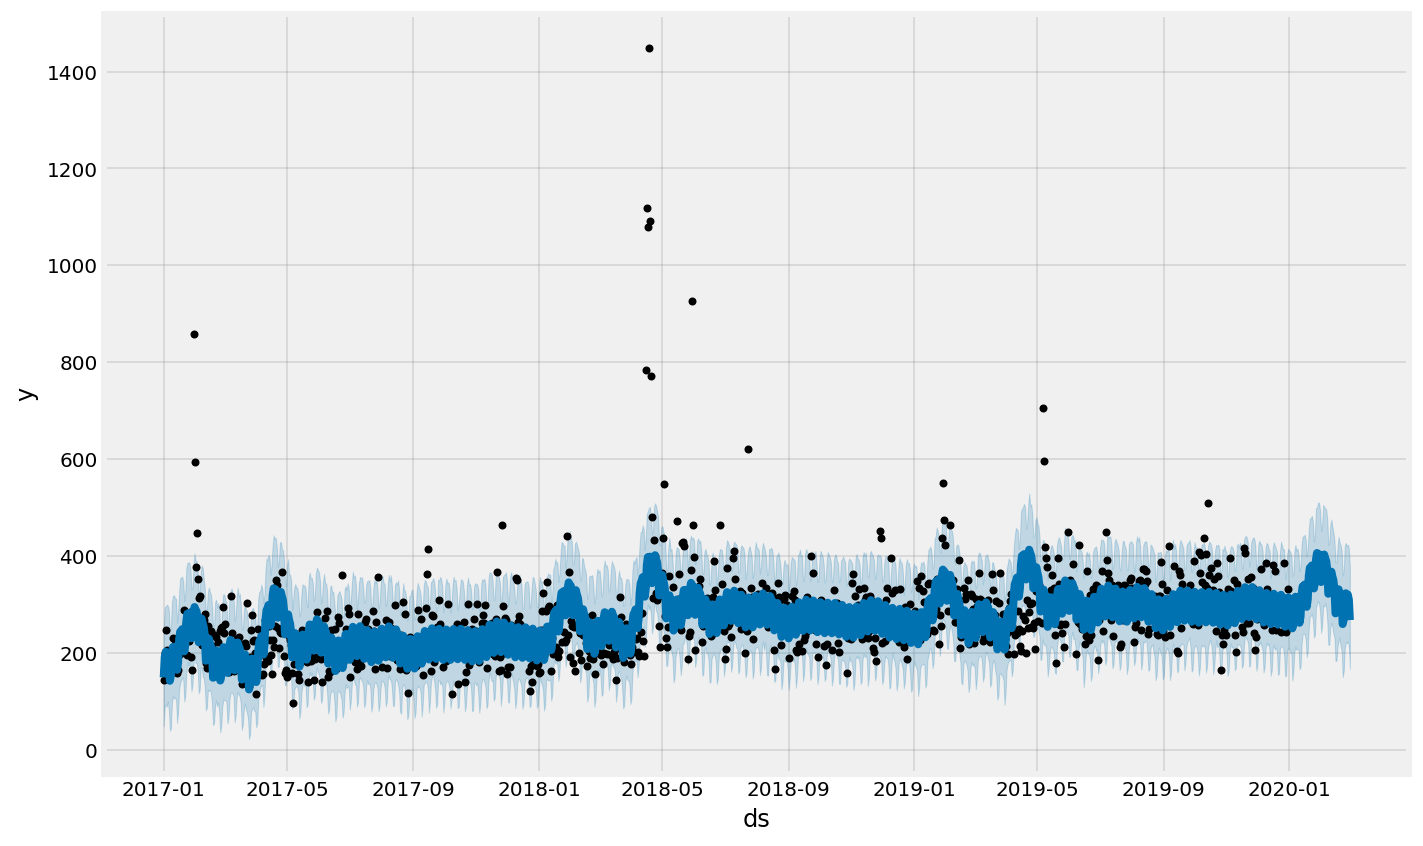

In [182]:
fig1 = m.plot(forecast)

In [53]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01,286.825647,74.192802,559.037517,286.825647,286.825647,25.016340,25.016340,25.016340,25.016340,25.016340,25.016340,0.0,0.0,0.0,311.841987
1,2018-03-02,287.478819,26.250897,513.678817,287.478819,287.478819,-26.398796,-26.398796,-26.398796,-26.398796,-26.398796,-26.398796,0.0,0.0,0.0,261.080023
2,2018-03-03,288.131991,-18.156880,443.351448,288.131991,288.131991,-82.091397,-82.091397,-82.091397,-82.091397,-82.091397,-82.091397,0.0,0.0,0.0,206.040594
3,2018-03-04,288.785163,-5.761099,477.095341,288.785163,288.785163,-48.362512,-48.362512,-48.362512,-48.362512,-48.362512,-48.362512,0.0,0.0,0.0,240.422651
4,2018-03-05,289.438335,50.483530,544.812540,289.438335,289.438335,3.540132,3.540132,3.540132,3.540132,3.540132,3.540132,0.0,0.0,0.0,292.978468


In [13]:
sentences = ["Starbucks has the best customer service.",  # positive sentence example
             "I hate the long lines at Starbucks.",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "I went to Starbucks to get a coffee.",]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs['compound'])))

Starbucks has the best customer service.------------------------- 0.6369
I hate the long lines at Starbucks.------------------------------ -0.5719
I went to Starbucks to get a coffee.----------------------------- 0.0


In [45]:


ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date) 
ax.axvline(close_date)

ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Positive and Negative Sentiment Percentages')
plt.show();

KeyError: 'created_utc'

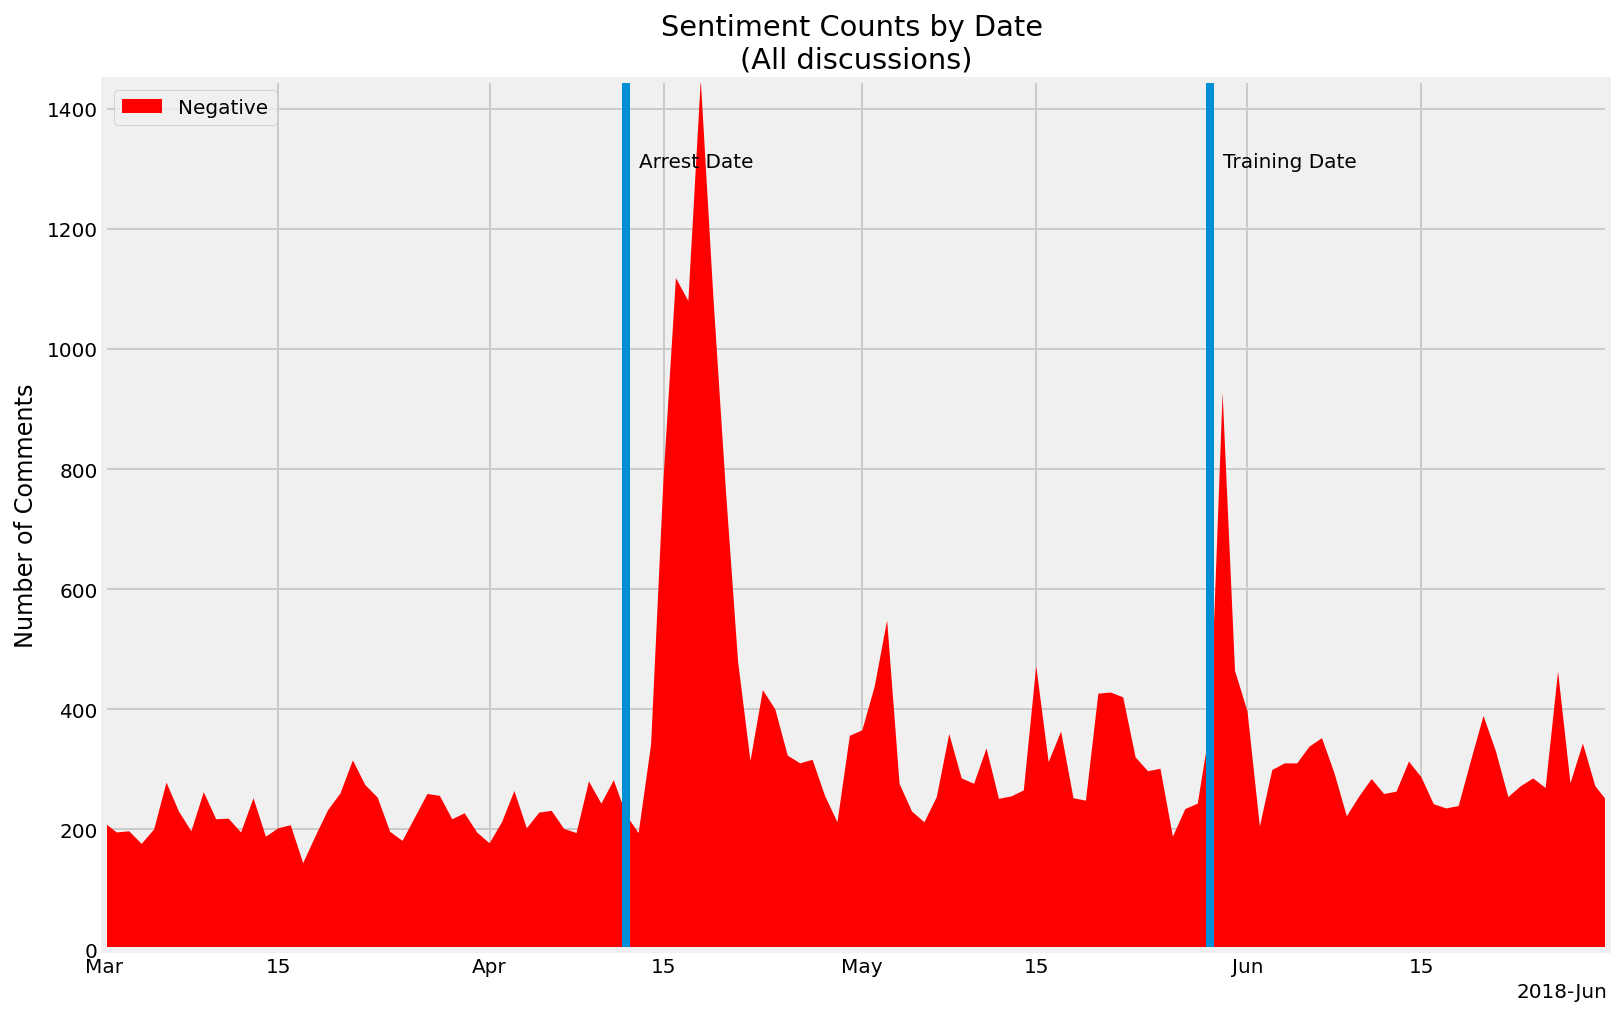

<Figure size 432x288 with 0 Axes>

In [57]:

# All Discussion Threads
from matplotlib.dates import AutoDateLocator
from matplotlib.dates import ConciseDateFormatter

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)


plt.figure(figsize=(12,8)) 
plt.stackplot(df['created_utc'],df["Negative"], labels=['Negative'],colors=['r'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date) 
ax.axvline(close_date)


ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
        
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(All discussions)')

plt.show()

plt.savefig('starbucks_sentiments_by_date.jpg')

# Observations


There was a spike of negative sentiment three days after the incident (April 12,2018) that dropped lower but not quite to the pre-incident levels. 

A second spike of negative sentiment occurred on May 29,2018 when Starbucks closed its stores for sensitivity training.

The ratio of positive sentiment to negative sentiment was stable throughout the year.

Mentions of Starbucks and the positive sentiment of the comments on website improved within 1 week.


# Conclusion

    


The incident that occurred during April 2018 had an observable impact on people's feelings about the company based on discussions on reddit.com. 


# Additional Information

https://www.inquirer.com/news/starbucks-incident-philadelphia-racial-bias-one-year-anniversary-stutter-dilworth-park-homeless-tables-20190412.html
    
    